In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Load Data
df_features_train = pd.read_pickle(r"../data_DE/day_ahead_features_train.pkl").dropna()
df_features_train = df_features_train.drop(['initial_frequency_value'],axis=1)
df_freq_train = pd.read_pickle(r"../data_DE/frequency_train.pkl").dropna()

df_features_test = pd.read_pickle(r"../data_DE/day_ahead_features_test.pkl").dropna()
df_features_test = df_features_test.drop(['initial_frequency_value'],axis=1)
df_freq_test = pd.read_pickle(r"../data_DE/frequency_test.pkl").dropna()

def transform_data(df_features, df_freq):
    common_index = df_features.index.intersection(df_freq.index)
    df_features = df_features.loc[common_index]
    df_features = df_features[~df_features.index.duplicated(keep='first')]
    df_freq = df_freq.loc[common_index]

    # Enrich features
    df_features['hour_of_day'] = df_features.index.hour
    df_features['day_of_week'] = df_features.index.dayofweek
    df_features['month_of_year'] = df_features.index.month
    df_features['freq_mean_lag_1'] = df_freq.mean(axis=1).shift(24)
    # df_features = df_features_train.resample('h').mean()

    df_freq = df_freq - 50.0
    return df_features, df_freq

def plot_predictions(actual, predicted, title):
    plt.figure(figsize=(20, 5))
    plt.plot(actual.head(400), label="actual")
    plt.plot(predicted.head(400), label="predicted")
    
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

def apply_standard_scaler(data, scaler):
    if scaler is None:
        scaler = StandardScaler()
    if isinstance(data, pd.DataFrame):
        # Fit and transform the data using StandardScaler
        scaled_data = scaler.fit_transform(data)
        # Return the scaled data as a DataFrame with the same column names and index
        return pd.DataFrame(scaled_data, index=data.index, columns=data.columns), scaler
    
    elif isinstance(data, pd.Series):
        # Reshape the series to a 2D array (required by StandardScaler)
        scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
        # Return the scaled data as a Series with the same index
        return pd.Series(scaled_data.flatten(), index=data.index, name=data.name), scaler
    
    else:
        raise TypeError("Input must be a pandas DataFrame or Series")
    
df_features_train, df_freq_train = transform_data(df_features_train, df_freq_train)
df_features_test, df_freq_test = transform_data(df_features_test, df_freq_test)

df_features_train, scaler = apply_standard_scaler(df_features_train, scaler=None)
df_features_test, scaler = apply_standard_scaler(df_features_test, scaler=scaler)

# df_features_train = scaler.fit_transform(df_features_train)
# df_features_test = scaler.transform(df_features_test)

In [8]:
df_features_train.reset_index().dropna()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [12]:
from darts.models import TFTModel
from darts import TimeSeries

# Convert the training and test data to TimeSeries objects
future_covariates_columns = ['solar_day_ahead', 'wind_on_day_ahead', 'wind_off_day_ahead',
                            'prices_day_ahead', 'load_day_ahead', 'load_ramp_day_ahead',
                            'total_gen_ramp_day_ahead', 'wind_off_ramp_day_ahead',
                            'wind_on_ramp_day_ahead', 'solar_ramp_day_ahead',
                            'price_ramp_day_ahead']
past_covariates_columns = ['hour_sin', 'hour_cos', 'hour_of_day', 'day_of_week', 'month_of_year', 'freq_mean_lag_1']

past_covariates_train = TimeSeries.from_dataframe(df_features_train.resample('h').first().fillna(method='ffill').reset_index(), 'timestamp', past_covariates_columns, fill_missing_dates=True, freq='H')
future_covariates_train = TimeSeries.from_dataframe(df_features_train.resample('h').first().fillna(method='ffill').reset_index(), 'timestamp', future_covariates_columns, fill_missing_dates=True, freq='H')
past_covariates_test = TimeSeries.from_dataframe(df_features_test.reset_index().dropna(), 'timestamp', past_covariates_columns, fill_missing_dates=True, freq='H')
future_covariates_test = TimeSeries.from_dataframe(df_features_test.reset_index().dropna(), 'timestamp', future_covariates_columns, fill_missing_dates=True, freq='H')

train_freq = TimeSeries.from_dataframe(df_freq_train.mean(axis=1).reset_index().rename(columns={0: 'freq_mean'}), 'timestamp', 'freq_mean', fill_missing_dates=True, freq='H')
test_freq = TimeSeries.from_dataframe(df_freq_test.mean(axis=1).reset_index().rename(columns={0: 'freq_mean'}), 'timestamp', 'freq_mean', fill_missing_dates=True, freq='H')

# Initialize and train the TFT model
model = TFTModel(
    input_chunk_length=24 * 7,  # Input window length
    output_chunk_length=24,  # Forecast horizon (1 hour)
    n_epochs=5
)

model.fit(train_freq, past_covariates=past_covariates_train, future_covariates=future_covariates_train)

/tmp/ipykernel_291112/1606321655.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  past_covariates_train = TimeSeries.from_dataframe(df_features_train.resample('h').first().fillna(method='ffill').reset_index(), 'timestamp', past_covariates_columns, fill_missing_dates=True, freq='H')
/home/qnlzgl/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)
/tmp/ipykernel_291112/1606321655.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_covariates_train = TimeSeries.from_dataframe(df_features_train.resample('h').first().fillna(method='ffill').reset_index(), 'timestamp', future_covariates_columns, fill_missing_dates=True, 

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


TFTModel(output_chunk_shift=0, hidden_size=16, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=168, output_chunk_length=168, n_epochs=5)

/tmp/ipykernel_291112/1955398630.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  past_covariates_test = TimeSeries.from_dataframe(df_features_test_extend.resample('h').first().fillna(method='ffill').reset_index(), 'timestamp', past_covariates_columns, fill_missing_dates=True, freq='H')
/home/qnlzgl/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/darts/timeseries.py:4870: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)
/tmp/ipykernel_291112/1955398630.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_covariates_test = TimeSeries.from_dataframe(df_features_test_extend.resample('h').first().fillna(method='ffill').reset_index(), 'timestamp', future_covariates_columns, fill_missing_date

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='timestamp'>

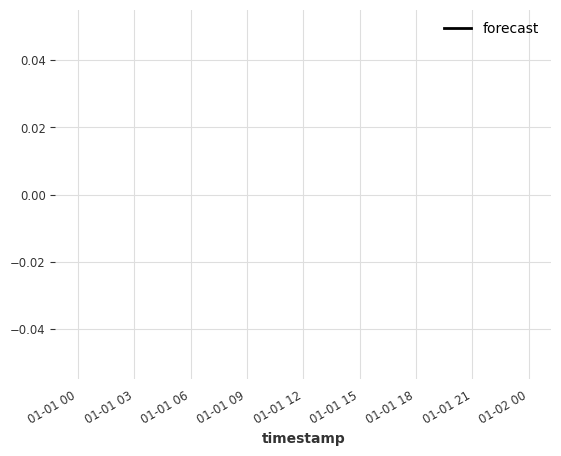

In [13]:
df_features_test_extend = pd.concat([df_features_train.tail(24 * 7), df_features_test], axis=0)
past_covariates_test = TimeSeries.from_dataframe(df_features_test_extend.resample('h').first().fillna(method='ffill').reset_index(), 'timestamp', past_covariates_columns, fill_missing_dates=True, freq='H')
future_covariates_test = TimeSeries.from_dataframe(df_features_test_extend.resample('h').first().fillna(method='ffill').reset_index(), 'timestamp', future_covariates_columns, fill_missing_dates=True, freq='H')

# Make predictions
pred_freq_mean_test = model.predict(n=6 * 30 * 24, past_covariates=past_covariates_test, future_covariates=future_covariates_test)
# model.pred
# Convert predictions to pandas Series for plotting
pred_freq_mean_test
pred_freq_mean_test.plot(label="forecast")
# test_freq.plot(label="true")

In [14]:
pred_freq_mean_test

<TimeSeries (DataArray) (timestamp: 4320, component: 1, sample: 1)>
array([[[nan]],

       [[nan]],

       [[nan]],

       ...,

       [[nan]],

       [[nan]],

       [[nan]]])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 2018-12-31T23:00:00 ... 2019-06-29T...
  * component  (component) object 'freq_mean'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:

mean_train, std_train, skew_train, kurtosis_train = pd.DataFrame(outputs_train).mean(axis=1), pd.DataFrame(outputs_train).std(axis=1), pd.DataFrame(outputs_train).skew(axis=1), pd.DataFrame(outputs_train).kurtosis(axis=1)
mean_test, std_test, skew_test, kurtosis_test = pd.DataFrame(outputs_test).mean(axis=1), pd.DataFrame(outputs_test).std(axis=1), pd.DataFrame(outputs_test).skew(axis=1), pd.DataFrame(outputs_test).kurtosis(axis=1)

std_pred_model = xgb.XGBRegressor().fit(inputs_train, std_train)
preds_std_test = pd.Series(std_pred_model.predict(inputs_test))
std_rsme = np.sqrt(np.mean((std_test - preds_std_test) ** 2))
print(f"Standard Deviation RMSE: {std_rsme}")

skew_pred_model = xgb.XGBRegressor().fit(inputs_train, skew_train)
preds_skew_test = pd.Series(skew_pred_model.predict(inputs_test))

kurtosis_pred_model = xgb.XGBRegressor().fit(inputs_train, kurtosis_train)
preds_kurtosis_test = pd.Series(kurtosis_pred_model.predict(inputs_test))

plot_predictions(std_test, preds_std_test, "Standard Deviation Prediction")
plot_predictions(skew_test, preds_skew_test, "Skewness Prediction")
plot_predictions(kurtosis_test, preds_kurtosis_test, "Kurtosis Prediction")

In [16]:
df_freq_test
freq_test_series = df_freq_test.stack().reset_index()
# freq_test_series[]
freq_test_series['timestamp'] = freq_test_series['timestamp'] + pd.to_timedelta(freq_test_series['level_1'], unit='s')
freq_test_series = freq_test_series[::60].set_index('timestamp')

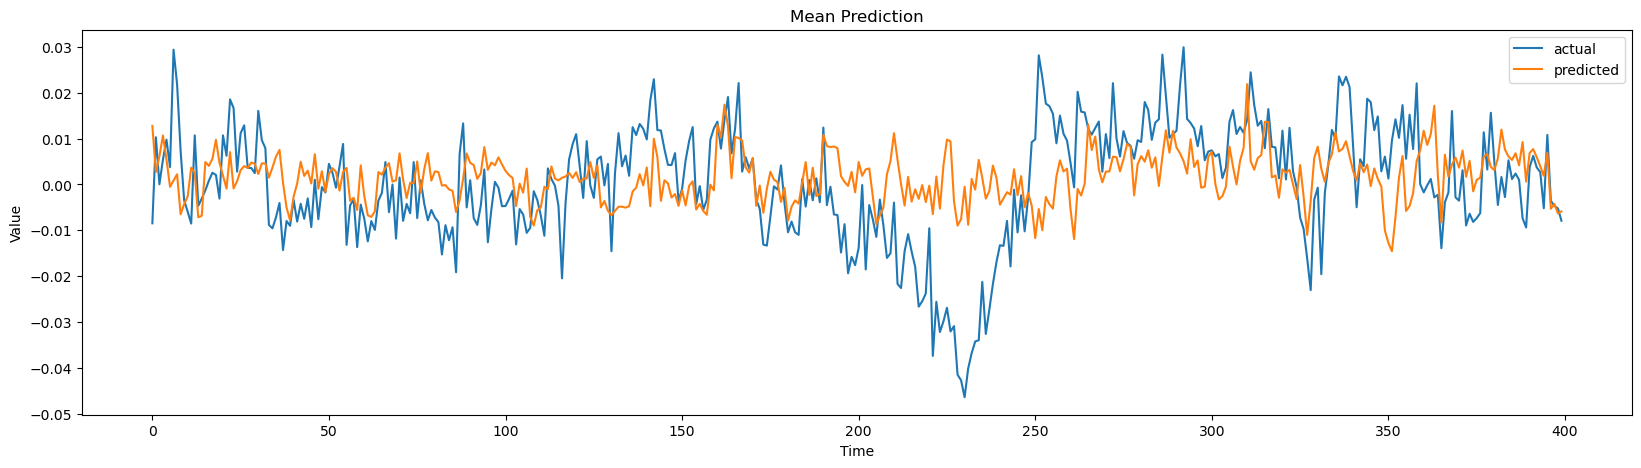

In [55]:
mean_pred_model = xgb.XGBRegressor().fit(inputs_train, mean_train)
preds_mean_test = pd.Series(mean_pred_model.predict(inputs_test))
plot_predictions(mean_test, preds_mean_test, "Mean Prediction")

In [139]:
# df_freq_train.mean(axis=1).reset_index().rename(columns={0: 'freq_mean'})

In [120]:
pred_freq_mean_test.pd_dataframe().dropna().to_pickle(r"../data_DE/freq_mean_predictions.pkl")

component,freq_mean
timestamp,


In [106]:
past_covariates_test

<TimeSeries (DataArray) (timestamp: 8738, component: 6, sample: 1)>
array([[[-5.82039275e-04],
        [ 1.41819942e+00],
        [-1.66097514e+00],
        [-1.01068781e+00],
        [-1.51718690e+00],
        [            nan]],

       [[ 3.65245803e-01],
        [ 1.36998495e+00],
        [-1.51626295e+00],
        [-1.01068781e+00],
        [-1.51718690e+00],
        [            nan]],

       [[ 7.06143083e-01],
        [ 1.22862729e+00],
        [-1.37155077e+00],
        [-1.01068781e+00],
        [-1.51718690e+00],
        [            nan]],
...
       [[-3.66409882e-01],
        [ 1.36998495e+00],
        [ 1.66740515e+00],
        [-1.51016453e+00],
        [ 1.60414001e+00],
        [-1.10786070e+00]],

       [[-5.82039275e-04],
        [ 1.41819942e+00],
        [-1.66097514e+00],
        [-1.01068781e+00],
        [ 1.60414001e+00],
        [-1.55660016e-01]],

       [[ 3.65245803e-01],
        [ 1.36998495e+00],
        [-1.51626295e+00],
        [-1.01068781e+00],
        [ 1.60414001e+00],
        [-6.40680759e-01]]])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 2019-01-01 ... 2019-12-31T01:00:00
  * component  (component) object 'hour_sin' 'hour_cos' ... 'freq_mean_lag_1'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### Old Model Plots

In [2]:
for idx, i in enumerate(df_features_train.columns):
    print(f"{idx} - {i}")
# Add hour of day, day of week, month of year, lagged frequency, lagged frequency squared, lagged frequency cubed as features


# Drop rows with NaN values created by shifting
# day_ahead_features_train.dropna(inplace=True)


0 - solar_day_ahead
1 - wind_on_day_ahead
2 - wind_off_day_ahead
3 - prices_day_ahead
4 - load_day_ahead
5 - load_ramp_day_ahead
6 - total_gen_ramp_day_ahead
7 - wind_off_ramp_day_ahead
8 - wind_on_ramp_day_ahead
9 - solar_ramp_day_ahead
10 - price_ramp_day_ahead
11 - hour_sin
12 - hour_cos


In [3]:
from supervised.automl import AutoML

# Initialize AutoML
automl = AutoML(mode="Explain", total_time_limit=3600)

# Train the model
automl.fit(inputs_train, mean_train)

# Make predictions
preds_mean_test = pd.Series(automl.predict(inputs_test).flatten())

# Plot predictions for test data
plot_predictions(mean_test, preds_mean_test, "Mean Prediction - Test Data")

# Calculate RMSE for mean prediction on test data
mean_rmse_test = np.sqrt(np.mean((mean_test - preds_mean_test) ** 2))
print(f"Mean RMSE (Test Data): {mean_rmse_test}")


# Make predictions for train data
preds_mean_train = pd.Series(automl.predict(inputs_train).flatten())

# Plot predictions for train data
plot_predictions(mean_train, preds_mean_train, "Mean Prediction - Train Data")

# Calculate RMSE for mean prediction on train data
mean_rmse_train = np.sqrt(np.mean((mean_train - preds_mean_train) ** 2))
print(f"Mean RMSE (Train Data): {mean_rmse_train}")


/home/qnlzgl/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.


Linear algorithm was disabled.
AutoML directory: AutoML_5
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.008906 trained in 0.23 seconds


/home/qnlzgl/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
/home/qnlzgl/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
/home/qnlzgl/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
/home/qnlzgl/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
/home/qnlzgl/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/dask/dataframe/_pyarrow

2_DecisionTree rmse 0.008431 trained in 6.86 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.007781 trained in 4.59 seconds
4_Default_NeuralNetwork rmse 0.00846 trained in 4.42 seconds
5_Default_RandomForest rmse 0.008324 trained in 5.11 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.007781 trained in 0.16 seconds
AutoML fit time: 26.51 seconds
AutoML best model: 3_Default_Xgboost
Mean RMSE (Test Data): 0.008682270563213504
Mean RMSE (Train Data): 0.006626295474260042


/tmp/ipykernel_56589/3879498452.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
/tmp/ipykernel_56589/3879498452.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


In [11]:
import matplotlib
matplotlib.use('TkAgg')  # or 'Qt5Agg' depending on your system

def plot_predictions(actual, predicted, title):
    plt.figure(figsize=(20, 5))
    plt.plot(actual.tail(800), label="actual")
    plt.plot(predicted.tail(800), label="predicted")
    
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

plot_predictions(mean_test, preds_mean_test, "Mean Prediction - Test Data")
plt.show() 


In [27]:
freq_test_series.head(3601)

,timestamp,level_1,0,timestamp_derived
0,2019-01-01 00:00:00,0,50.008999,2019-01-01 00:00:00
1,2019-01-01 00:00:00,1,50.008999,2019-01-01 00:00:01
2,2019-01-01 00:00:00,2,50.007999,2019-01-01 00:00:02
3,2019-01-01 00:00:00,3,50.007000,2019-01-01 00:00:03
4,2019-01-01 00:00:00,4,50.007000,2019-01-01 00:00:04
...,...,...,...,...
3596,2019-01-01 00:00:00,3596,50.007999,2019-01-01 00:59:56
3597,2019-01-01 00:00:00,3597,50.008999,2019-01-01 00:59:57
3598,2019-01-01 00:00:00,3598,50.007999,2019-01-01 00:59:58
3599,2019-01-01 00:00:00,3599,50.007999,2019-01-01 00:59:59


In [108]:
mean_test += 50.0
preds_mean_test += 50
# preds_mean_test
# Merge mean test 
ds_mean_test = pd.Series(mean_test)
ds_mean_test.index = index_test
# frequency_test

ds_std_test = pd.Series(std_test)
ds_std_test.index = index_test

ds_mean_test_pred = pd.Series(preds_mean_test)
ds_mean_test_pred.index = index_test   

ds_std_test_pred = pd.Series(preds_std_test)
ds_std_test_pred.index = index_test


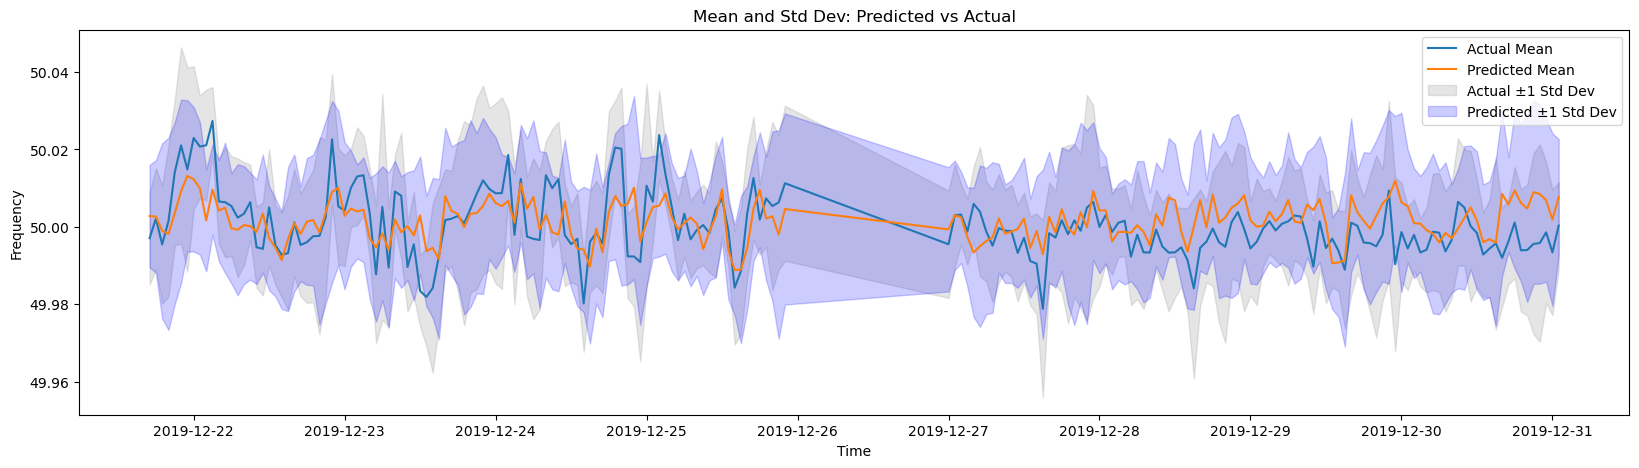

In [120]:
# Plot the mean and std
plt.figure(figsize=(20, 5))
plt.plot(ds_mean_test.tail(200), label="Actual Mean")
plt.plot(ds_mean_test_pred.tail(200), label="Predicted Mean")
plt.fill_between(ds_mean_test.tail(200).index, 
                 (ds_mean_test - ds_std_test).tail(200), 
                 (ds_mean_test + ds_std_test).tail(200), 
                 color='gray', alpha=0.2, label="Actual ±1 Std Dev")
plt.fill_between(ds_mean_test_pred.tail(200).index, 
                 (ds_mean_test_pred - ds_std_test_pred).tail(200), 
                 (ds_mean_test_pred + ds_std_test_pred).tail(200), 
                 color='blue', alpha=0.2, label="Predicted ±1 Std Dev")

plt.title("Mean and Std Dev: Predicted vs Actual")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [ ]:
mean_test

In [29]:

# Plot the mean and std
plt.figure(figsize=(20, 5))
plt.plot(mean_test.tail(200), label="Actual Mean")
plt.plot(mean_test_pred.tail(200), label="Predicted Mean")
plt.fill_between(mean_test.tail(200).index, 
                 (mean_test - std_test).tail(200), 
                 (mean_test + std_test).tail(200), 
                 color='gray', alpha=0.2, label="Actual ±1 Std Dev")
plt.fill_between(mean_test_pred.tail(200).index, 
                 (mean_test_pred - std_test_pred).tail(200), 
                 (mean_test_pred + std_test_pred).tail(200), 
                 color='blue', alpha=0.2, label="Predicted ±1 Std Dev")

plt.title("Mean and Std Dev: Predicted vs Actual")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.legend()
plt.show()

NameError: name 'mean_test_pred' is not defined

In [125]:
df_freq_test['mean'] = ds_mean_test
df_freq_test['std'] = ds_std_test
df_freq_test['mean_pred'] = ds_mean_test_pred
df_freq_test['std_pred'] = ds_std_test_pred

In [136]:
df_freq_test.iloc[i, :3600]

0       50.014999
1       50.014999
2       50.014999
3       50.014999
4       50.012997
          ...    
3595    49.989002
3596    49.990002
3597    49.990002
3598    49.990002
3599    49.991001
Name: 2019-01-09 07:00:00, Length: 3600, dtype: float64

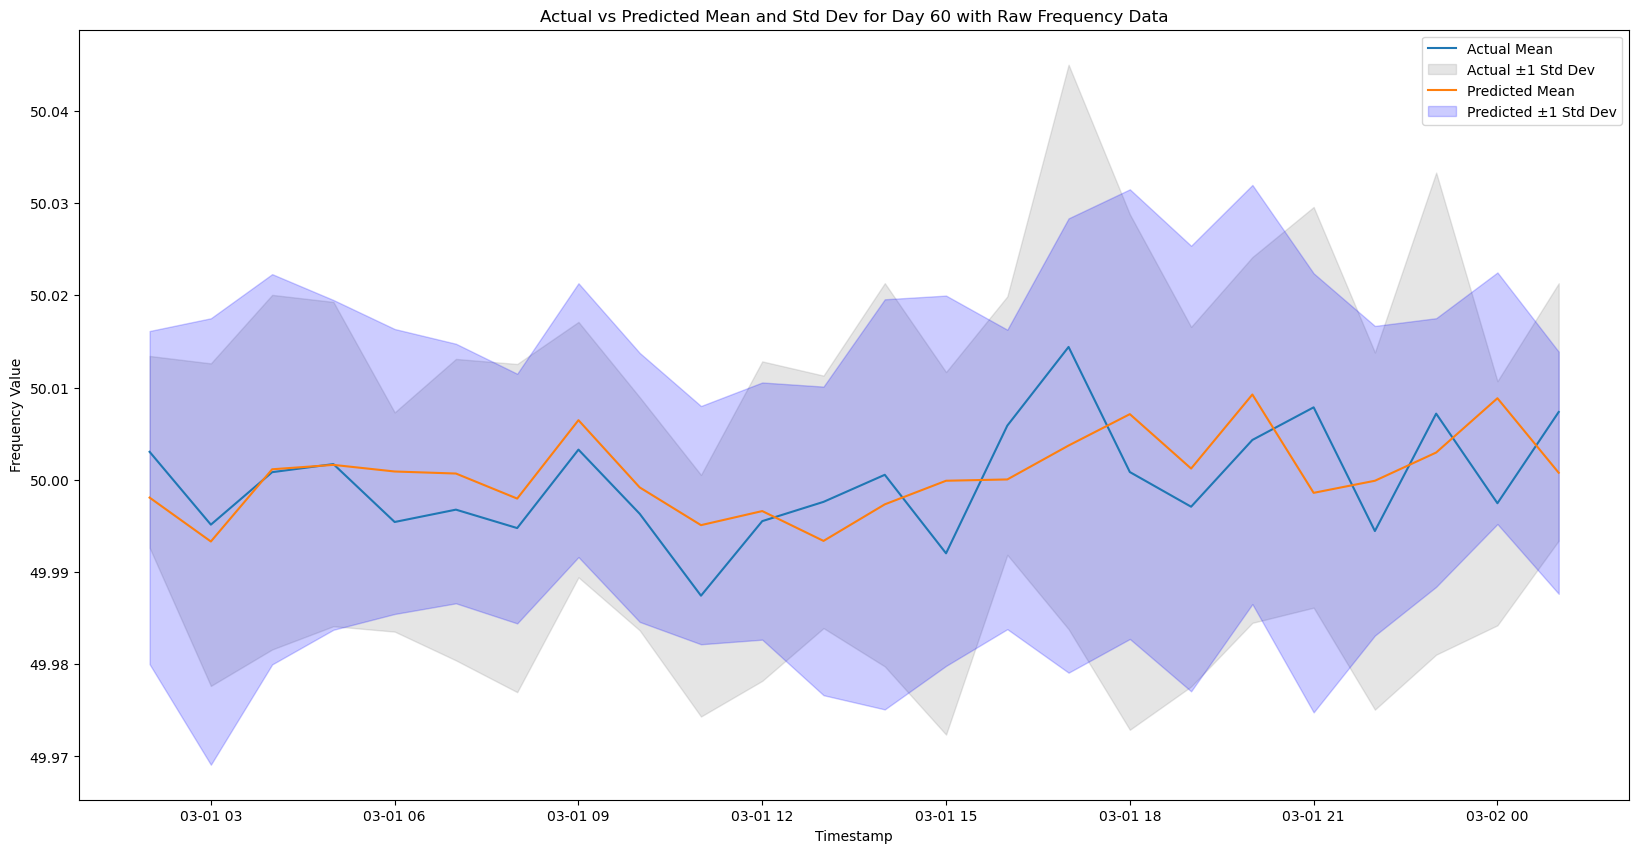

In [144]:
# Calculate the start and end indices for the Nth day
N = 60
start_idx = (N - 1) * 24
end_idx = N * 24

plt.figure(figsize=(20, 10))

# Plot actual mean and std
plt.plot(df_freq_test.index[start_idx:end_idx], ds_mean_test[start_idx:end_idx], label="Actual Mean")
plt.fill_between(df_freq_test.index[start_idx:end_idx], 
                 (ds_mean_test - ds_std_test)[start_idx:end_idx], 
                 (ds_mean_test + ds_std_test)[start_idx:end_idx], 
                 color='gray', alpha=0.2, label="Actual ±1 Std Dev")

# Plot predicted mean and std
plt.plot(df_freq_test.index[start_idx:end_idx], ds_mean_test_pred[start_idx:end_idx], label="Predicted Mean")
plt.fill_between(df_freq_test.index[start_idx:end_idx], 
                 (ds_mean_test_pred - ds_std_test_pred)[start_idx:end_idx], 
                 (ds_mean_test_pred + ds_std_test_pred)[start_idx:end_idx], 
                 color='blue', alpha=0.2, label="Predicted ±1 Std Dev")

plt.title(f"Actual vs Predicted Mean and Std Dev for Day {N} with Raw Frequency Data")
plt.xlabel("Timestamp")
plt.ylabel("Frequency Value")
plt.legend()
plt.show()


In [61]:
lower_bound = mean_test - std_test
upper_bound = mean_test + std_test

plt.figure(figsize=(20, 5))
plt.plot(df_freq_test.head(200), label="Actual Frequency")
plt.plot(mean_test.head(200), label="Predicted Mean Frequency")
plt.fill_between(mean_test.head(200).index, lower_bound.head(200), upper_bound.head(200), color='gray', alpha=0.2, label="Predicted ±1 Std Dev")

plt.title("Predicted Frequency with Mean ± 1 Std Dev")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [47]:
# freq_2015 = pd.read_csv(f"/home/qnlzgl/sequence-model-and-gaussian-process-for-frequency-prediction-main/data_DE/DE/2015.csv", header=None, names=['timestamp', 'freq'])
# freq_2015['timestamp'] = pd.to_datetime(freq_2015['timestamp'])
# freq = freq_2015.set_index('timestamp')
# freq.sort_index(inplace=True)